# Secret Whiteboard

## Team Members

Fenno Boomgaarden (Fach-Bachelor Informatik)

Hauke Redemann (Fach-Bachelor Informatik)

Keno Rott (Fach-Bachelor Informatik)

# Use cases

## Privacy in real-life video streaming

- In common screen-capturing softwares like OBS it is possible to select which windows with non-sensitive information are captured.
- Streaming in real-life **has no mechanisms** like that.
- The only option to protect the personal information of the streamer and/or others is **image processing**.
- **Hide sensitive information** while streaming on platforms like YouTube and Twitch.

For example a streamer shows his/her appartment to his/her viewers and (s)he has some sensitive information on the kitchen fridge (s)he wants to hide.

## Lecture recording software

- Some universities use **automated systems** for lecture recording.
- Lectures may contain **sensistive data** that should not be public:
  - Access credentials to private webservers
  - Copyrighted information
  - Solutions for exam exercises (so they can be used again in the future)
- Provide a way to hide sensitive information **without manually editing** the video.

# Project Milestones

## 0. Project Setup

### Install dependencies

In [36]:
#!pip install opencv-python==4.1.1.26

### Imports

In [37]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import io
import math

### Helper functions

In [48]:
def create_frame(path):
    return Frame(io.imread(path))

def plot_image_data(images, data_attribute="data"):
    cols = 2
    rows = math.ceil(len(images) / cols)
    plt.figure(figsize=(20, 5 * rows))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(getattr(image, data_attribute), cmap="gray")
    plt.tight_layout()
    plt.show()

def apply_threshold(data):
    out = cv.GaussianBlur(data, (5, 5), 0)
    out = cv.adaptiveThreshold(out, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 201, 8)
    return out

def find_contours_filtered(data):
    contours, hierarchy = cv.findContours(data, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    for i, element in reversed(list(enumerate(hierarchy[0]))):
        if element[2] < 0:
            del contours[i]
    
    return contours

def detect_rectangles(contours):
    rectangles = []
    for contour in contours:
        approx = cv.approxPolyDP(contour, cv.arcLength(contour, True) * 0.02, True)
        if len(approx) == 4 and cv.isContourConvex(approx):
            rectangles.append(approx)
    return rectangles

# based on https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/
def order_points(points):
    pts = np.float32(points)
    r = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    r[0] = pts[np.argmin(s)]
    r[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    r[1] = pts[np.argmin(diff)]
    r[3] = pts[np.argmax(diff)]

    return r

def create_transformed_sub_image(data, rect):
    rows, cols = data.shape
    
    dst = []

    pts1 = order_points([rect[0][0],rect[1][0],rect[2][0],rect[3][0]])
    pts2 = np.float32([[0, 0], [cols, 0], [cols, rows], [0, rows]])
    if data[int(pts1[0][1]-2)][int(pts1[0][0]-2)] != 0:
        m = cv.getPerspectiveTransform(pts1, pts2)
        dst = cv.warpPerspective(data, m, (cols, rows))
    
    return dst

def extract_slices(data, margin, sub_margin):
    v_length = len(data)
    h_length = len(data[0])
    left = data[0:v_length, 0:int(v_length * margin)]
    left = np.transpose(left)
    top = data[0:int(h_length * margin), 0:h_length]
    right = data[0:v_length, h_length-int(v_length * margin):h_length]
    right = np.transpose(right)
    bottom = data[v_length-int(h_length * margin):v_length, 0:h_length]
    
    slices = [left, top, right, bottom]
    for i, s in enumerate(slices):
        slice_length = len(s)
        slices[i] = s[int(slice_length * sub_margin):slice_length-int(slice_length * sub_margin)][:]
    
    return slices

def create_line_data(data):
    line_data = np.zeros(len(data[0]))
    data = np.array(data)
    
    contours, hierarchy = cv.findContours(data, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for i, cnt in enumerate(contours):
        leftmost = tuple(cnt[cnt[:, :, 0].argmin()][0])[0]
        rightmost = tuple(cnt[cnt[:, :, 0].argmax()][0])[0]
        length = rightmost - leftmost
        line_data[leftmost:rightmost] = np.ones(length)
    
    return line_data

def check_line_dashed(line_data, max_dash_length_pct):
    last_pixel = 0
    distance = 0
    result = True
    for pixel in line_data:
        distance += 1
        if pixel != last_pixel:
            if distance > len(line_data) * max_dash_length_pct:
                result = False
                break
            distance = 0
            last_pixel = pixel
    
    return result

def blur_rectangle(image, rect):
    rows, cols, layers = image.shape
    
    dst = []

    pts1 = order_points([rect[0][0],rect[1][0],rect[2][0],rect[3][0]])
    pts2 = np.float32([[0, 0], [cols, 0], [cols, rows], [0, rows]])
    m = cv.getPerspectiveTransform(pts1, pts2)
    dst = cv.warpPerspective(image, m, (cols, rows))
    
    dst = dst * 0 #cv.GaussianBlur(dst, (15, 15), 100)

    return cv.warpPerspective(dst, m, (cols, rows), image, cv.WARP_INVERSE_MAP, cv.BORDER_TRANSPARENT)

class Image:
    def __init__(self, data):
        self.data = data

class Frame(Image):
    def __init__(self, data):
        super().__init__(cv.cvtColor(data, cv.COLOR_BGR2GRAY))
        self.original_data = data
        self.contours = None
        self.rectangles = None
        self.sub_images = []

class SubImage(Image):
    def __init__(self, data, rectangle):
        super().__init__(data)
        self.rectangle = rectangle
        self.slices = []

class Slice(Image):
    def __init__(self, data):
        super().__init__(data)
        self.line_data = None

### Read images


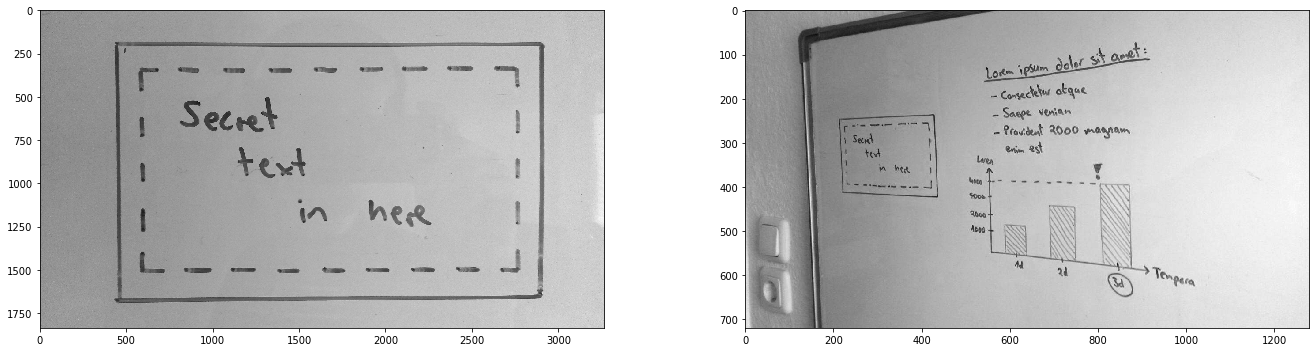

In [39]:
paths = [
    "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/samples/sample0.jpg",
    "https://raw.githubusercontent.com/uol-mediaprocessing/group-projects-secret-whiteboard/master/img/samples/sample5.jpg"
]

frames = [create_frame(path) for path in paths]

plot_image_data(frames)

## 1. Preprocessing
Differentiate the drawing from the whiteboard background and filter out light reflections.
- Gaussian Blur (https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html)
- Adaptive Thresholding (https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
- Erosion/Dilatation (https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html)
- Canny Edge Detection

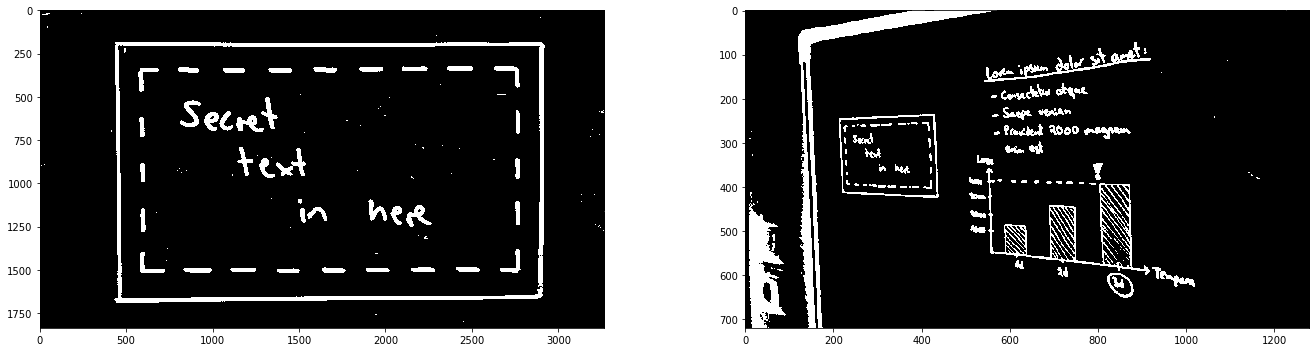

In [40]:
for frame in frames:
    frame.data = apply_threshold(frame.data)

plot_image_data(frames)

## 2. Contour detection and approximation
Detect all contours in the thresholded image and approximate contours with less vertices.
- Contour detection (https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html)
- Contour approximation (https://docs.opencv.org/master/dd/d49/tutorial_py_contour_features.html)

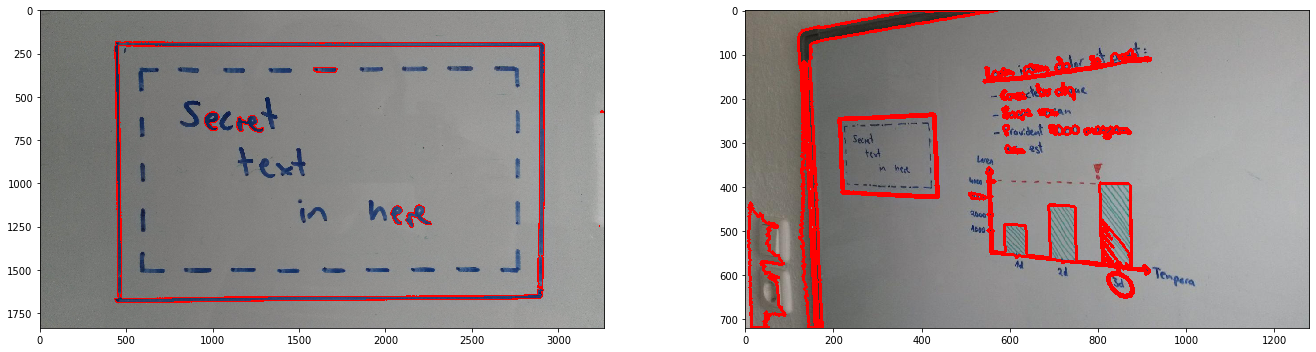

In [41]:
for frame in frames:
    frame.contours = find_contours_filtered(frame.data)

display_images = [cv.drawContours(frame.original_data.copy(), frame.contours, -1, (255, 0, 0), 5) for frame in frames]
plot_image_data(display_images)

## 3. Shape recognition
Detect rectangles based on the number of boundary points of the approximated contour, contour properties and all angles.

- Number of boundary points = 4?
- How rectangular is the shape?

  $Extent = \frac{Object Area}{Bounding Rectangle Area}$
  
- Angles = 90°?

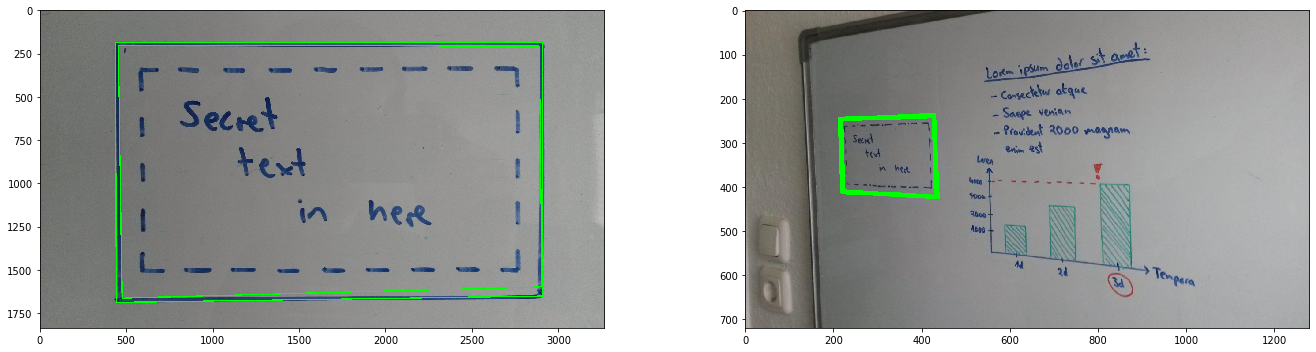

In [42]:
for frame in frames:
    frame.rectangles = detect_rectangles(frame.contours)

display_images = [cv.drawContours(frame.original_data.copy(), frame.rectangles, -1, (0, 255, 0), 5) for frame in frames]
plot_image_data(display_images)

## 4. Pattern detection
Find dashed lines inside the rectangles to determine if the corresponding area should be blackened.

### Create transformed sub-images

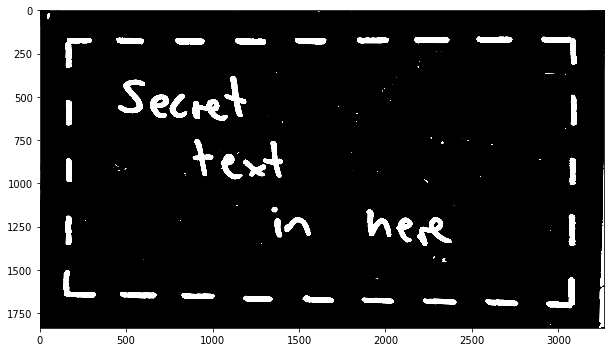

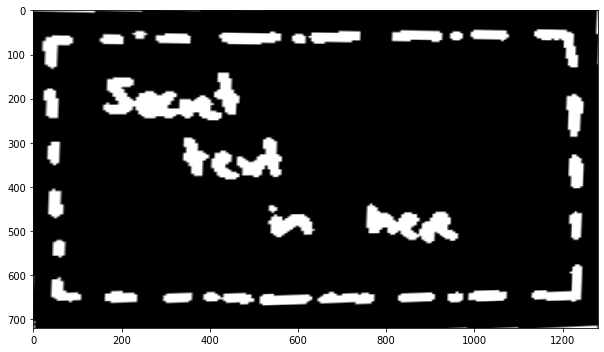

In [43]:
for frame in frames:
    for rectangle in frame.rectangles:
        data = create_transformed_sub_image(frame.data, rectangle)
        if len(data) > 0:
            frame.sub_images.append(SubImage(data, rectangle))
    plot_image_data(frame.sub_images)

### Image Extraction 
Extract all margin areas (left, right, bottom, top) as separate images.

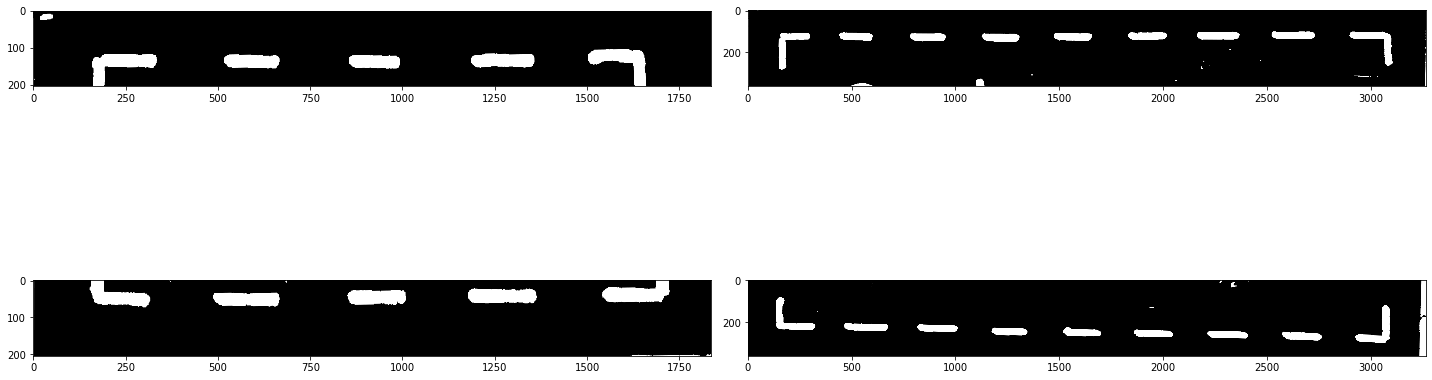

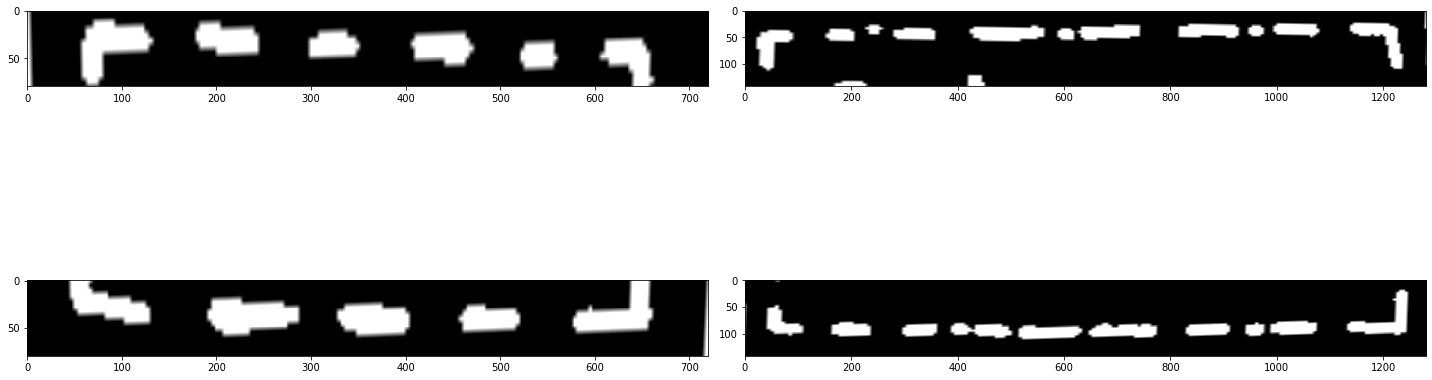

In [44]:
for frame in frames:
    for sub_image in frame.sub_images:
        sub_image.slices = [Slice(data) for data in extract_slices(sub_image.data, 1/7, 1/9)]
        plot_image_data(sub_image.slices)

### Detect dashed lines
- Create a 1-dimensional array with the same width as the current area.
- Initialize the array with zeroes.
- Detect contours of line segments.
- Get leftmost and rightmost pixel of the outline.
- Set all corresponding x values in the array to 255 (interval $[leftmost,rightmost]$).

In [45]:
for frame in frames:
    for sub_image in frame.sub_images:
        for sli in sub_image.slices:
            sli.line_data = create_line_data(sli.data)

In [46]:
for frame in frames:
    for sub_image in frame.sub_images:
        sub_image.valid = np.all([check_line_dashed(sli.line_data, 1/6) for sli in sub_image.slices])

## 5. Image Manipulation
Draw and fill out a rectangular shape (bounding rectangle of outer contour) for every detected pattern.

True


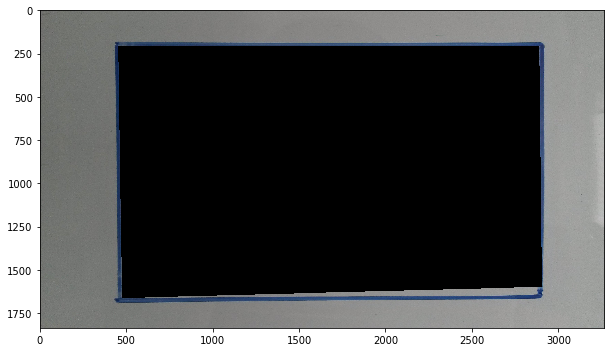

True


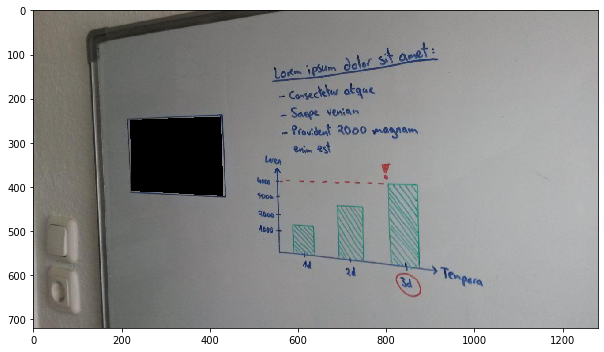

In [47]:
for frame in frames:
    for sub_image in frame.sub_images:
        print(sub_image.valid)
        if sub_image.valid:
            frame.original_data = blur_rectangle(frame.original_data, sub_image.rectangle)

    plot_image_data([frame], data_attribute="original_data")